# Code

In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import sys
from pathlib import Path
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

In [3]:
ROOT_DIR = os.path.dirname(os.path.abspath('.'))
original_files_dir = os.path.join(ROOT_DIR, 'dataset', 'original_files')
processed_files_dir = os.path.join(ROOT_DIR, 'dataset', 'processed_files')
rna_rna_files_dir = os.path.join(ROOT_DIR, 'dataset', 'rna_rna_pairs')

In [4]:
df = pd.read_csv(os.path.join(processed_files_dir,"df_annotation_files_cleaned.csv"))
rs_rg = pd.read_csv(os.path.join(original_files_dir, 'rise_paris_tr.new.mapped_interactions.tx_regions.txt'), '\t')
tr_anns = pd.read_csv(os.path.join(original_files_dir, 'tx_regions.ens84.txt'), sep = '\t')
ens_gene_mapping = pd.concat([rs_rg[['ensembl_transcript_id_1', 'gene_id1']].rename({'ensembl_transcript_id_1':'ensembl_transcript_id', 'gene_id1':'gene_id'}, axis = 1), 
           rs_rg[['ensembl_transcript_id_2', 'gene_id2']].rename({'ensembl_transcript_id_2':'ensembl_transcript_id',  'gene_id2':'gene_id'}, axis = 1)
          ], axis = 0).drop_duplicates()
tr_anns = tr_anns.merge(ens_gene_mapping, left_on = 'ensembl_transcript_id', right_on = 'ensembl_transcript_id', how = 'inner')

/home/gbini/miniconda3/envs/rnarna/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/gbini/miniconda3/envs/rnarna/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/gbini/miniconda3/envs/rnarna/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Script per distribuzioni

In [5]:
tr_anns['CDS_start'] = tr_anns.apply(lambda x: int(x['UTR5']) \
                                     if (x['UTR5'] not in ['/', 'UTR5']) else np.nan, axis=1)
tr_anns['CDS_end'] = tr_anns.apply(lambda x: int(x['CDS']) \
                                   if (x['CDS'] not in ['/', 'CDS']) else np.nan, axis=1)
tr_anns['CDS_length'] = tr_anns['CDS_end']-tr_anns['CDS_start'] 
tr_anns['CDS_ratio'] = tr_anns.apply(lambda x: int(x['CDS_length'])/int(x['length']) \
                                      if (np.isnan(x['CDS_length']) == False) else 0, axis=1)

Calcoliamo il valore atteso dei pixel CDS nella matrice di contatto tra gli rna.

In [6]:
df_res = tr_anns[['CDS_ratio', 'gene_id']].merge(df, left_on = 'gene_id', right_on = 'gene1', how = 'inner').rename(
    {'CDS_ratio':'CDS_ratio_gene1'}, axis = 1).drop('gene_id', axis = 1)
df_res = tr_anns[['CDS_ratio', 'gene_id']].merge(df_res, left_on = 'gene_id', right_on = 'gene2', how = 'inner').rename(
    {'CDS_ratio':'CDS_ratio_gene2'}, axis = 1).drop('gene_id', axis = 1)
df_res['expected_CDS_pixels'] =  df_res['CDS_ratio_gene2']/2 + df_res['CDS_ratio_gene1']/2
df_res['expected_CDS_CDS_pixels'] =  df_res['CDS_ratio_gene2'] * df_res['CDS_ratio_gene1']
assert df_res.shape[0] == df.shape[0]

Ora vediamo laddove ci sono i CDS quali sono le distribuzioni attese. Quelle veramente campionate non le sappiamo perche non ho salvato le coordinate delle finestre usate per training e test. Pero possiamo gia dire qualcosa su queste. 

In [7]:
at_least_one_cds = df_res[df_res['expected_CDS_pixels'] > 0]
perc = at_least_one_cds.shape[0]/df_res.shape[0] * 100
print(perc)

84.41333247704065


L'86% delle matrici di contatto hanno una probabilitá positiva di avere una regione CDS all'interno.

Le restanti matrici di contatto è tra non-protein-coding genes.

Text(0.5, 0, 'Expected CDS pixels in contact matrix')

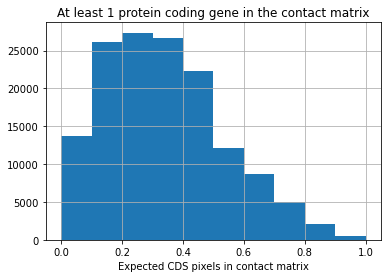

In [8]:
plt.title('At least 1 protein coding gene in the contact matrix')
at_least_one_cds['expected_CDS_pixels'].hist()
plt.xlabel('Expected CDS pixels in contact matrix')

A questo punto vediamo i casi che possono essere problematici: quando entrambi i geni sono protein-coding. In questo caso sappiamo che c'è un rischio di campionare tanti CDS-CDS nei negativi, che sappiamo essere poco propensi all'interazione nel set dei positivi (3% dei positivi ha un interazione in regioni cds-cds). 

NB: Nel 60% dei dati questo problema non si pone, le distribuzioni di positivi e negativi sono assolutamente confrontabili.

38.70832141334999


Text(0.5, 0, 'Expected CDS pixels in contact matrix')

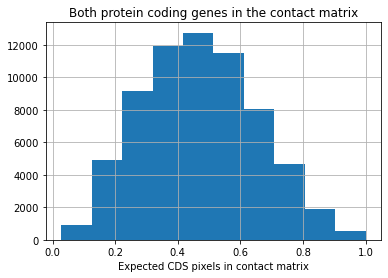

In [9]:
both_protein_coding = df_res[(df_res['CDS_ratio_gene2'] > 0) & (df_res['CDS_ratio_gene1'] > 0)]
perc = both_protein_coding.shape[0]/df_res.shape[0] * 100
print(perc)

plt.title('Both protein coding genes in the contact matrix')
both_protein_coding['expected_CDS_pixels'].hist()
plt.xlabel('Expected CDS pixels in contact matrix')

/tmp/ipykernel_1658/3796410632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_protein_coding['prob_of_sampling_cds_cds'] = both_protein_coding['CDS_ratio_gene2']*both_protein_coding['CDS_ratio_gene1']


Text(0.5, 0, 'Expected probability of sampling a CDS-CDS pixel in contact matrix')

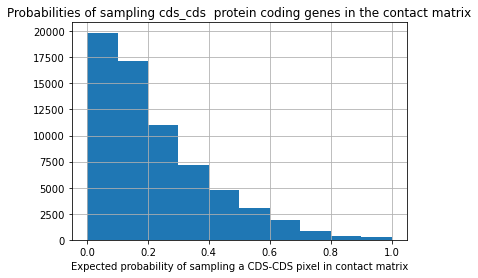

In [10]:
both_protein_coding['prob_of_sampling_cds_cds'] = both_protein_coding['CDS_ratio_gene2']*both_protein_coding['CDS_ratio_gene1']
plt.title('Probabilities of sampling cds_cds  protein coding genes in the contact matrix')
both_protein_coding['prob_of_sampling_cds_cds'].hist()
plt.xlabel('Expected probability of sampling a CDS-CDS pixel in contact matrix')

In [11]:
np.mean(both_protein_coding[both_protein_coding['there_is_interaction'] == False]['prob_of_sampling_cds_cds'])

0.227445296537671

Mediamente, ci aspettiamo che il 21.5% dei pixel delle contact matrix nel set dei negativi (nel 32% dei casi problematici) sia CDS-CDS, mentre invece nei positivi questa percentuale è pari soltanto al 3%.

### Hyperparameter setting (dataloader)

In [ ]:
positive = df_res[df_res.there_is_interaction == True]
negative = df_res[df_res.there_is_interaction == False]
assert positive.shape[0] + negative.shape[0] == df_res.shape[0]

Vorrei settare gli hp tali che il valore atteso dei pixel CDS-CDS sia pari sia nel set dei positivi che nel set dei negativi. Assumiamo che nei positivi la probabilita di interazione tra CDS-CDS sia 0% (Adri ha detto di eliminare dal set dei positivi tutti gli interattori in regioni CDS-CDS perche possono essere falsi positivi).

Se tutte le coppie di positivi fossero interagenti in un punto a caso nella matrice di contatto, il valore atteso dei pixel CDS nel set dei positivi sarebbe calcolabile come:

In [13]:
positive['expected_CDS_CDS_pixels'].mean()

0.08578711172696872

Tuttavia, la finestra viene presa in un intorno della regione di interazione (e nella regione di interazione questo valore è 0, quindi mi aspetto che nel suo intorno questa probabilitá sia inferiore). Quindi è in quell'intorno che noi dobbiamo calcolare il valore atteso dei pixel CDS nella matrice di contatto.

Prendiamo un intorno di 500 pixels, che mi sembra sensato come valore: consideriamo che i sample possono essere al massimo 512*512, e non sono sempre centrati nella regione di interazione. Io assumerò che questa probabilitá che vado a stimare centrando sempre in questa stima l'interazione, sará rappresentativa delle distribuzioni del dataloader (in cui invece la dimensione varierá e nei sample le regioni di interazione possono essere un po' decentrate.

In [14]:
interval_length = 500
x = positive.loc[1]

def cds_ratio_interval1(x):
    if x.CDS_ratio_gene1 == 0:
        return 0

    elif x.CDS_ratio_gene1 == 1:
        return 1

    else:
        gene1 = x.gene1

        gene_info = tr_anns[tr_anns.gene_id == gene1].iloc[0]
        cds_start, cds_end = int(gene_info.CDS_start), int(gene_info.CDS_end)

        center_gene1 = int(x.x1 + x.w/2)
        inf1 = int(max(0, center_gene1-(interval_length/2)))
        sup1 = int(min(center_gene1+(interval_length/2), int(gene_info.length)))

        cds_intersection = set(range(inf1, sup1)).intersection(range(cds_start, cds_end))
        cds_ratio_interval1 = (len(cds_intersection))/(sup1-inf1)
        
        return cds_ratio_interval1
    
def cds_ratio_interval2(x):
    if x.CDS_ratio_gene2 == 0:
        return 0

    elif x.CDS_ratio_gene2 == 1:
        return 1

    else:
        gene2 = x.gene2

        gene_info = tr_anns[tr_anns.gene_id == gene2].iloc[0]
        cds_start, cds_end = int(gene_info.CDS_start), int(gene_info.CDS_end)

        center_gene2 = int(x.y1 + x.h/2)
        inf2 = int(max(0, center_gene2-(interval_length/2)))
        sup2 = int(min(center_gene2+(interval_length/2), int(gene_info.length)))

        cds_intersection = set(range(inf2, sup2)).intersection(range(cds_start, cds_end))
        cds_ratio_interval2 = (len(cds_intersection))/(sup2-inf2)
        
        return cds_ratio_interval2

In [15]:
cds_ratio_interval1(x)

1

In [16]:
cds_ratio_interval2(x)

0

In [ ]:
start_time = time.time()
positive['cds_ratio_interval1'] = positive.apply(cds_ratio_interval1, axis = 1)
print(f"Total minutes: {(time.time() - start_time)/60}")

In [ ]:
start_time = time.time()
positive['cds_ratio_interval2'] = positive.apply(cds_ratio_interval2, axis = 1)
print(f"Total minutes: {(time.time() - start_time)/60}")

In [ ]:
positive['expected_cds_cds_around_interval'] = positive['cds_ratio_interval1']*positive['cds_ratio_interval2']

In [ ]:
print(positive['expected_cds_cds_around_interval'].mean())

Il valore qui sopra è il valore atteso dei pixel cds-cds nell'intorno (nella finestra) attorno alle interazioni. (easypos & hardpos)

In [ ]:
print(negative['expected_CDS_CDS_pixels'].mean())

Il valore qui sopra è invece il valore atteso dei pixel cds-cds nei negativi. (easyneg)

In [ ]:
print(positive['expected_CDS_CDS_pixels'].mean())

Negli hardneg, invece, assumiamo che il valore atteso sia invece pari a quello qui sopra (forse potrebbe essere leggermente piu alto perche è al di fuori delle interazioni ma piu o meno siamo li). 

(E_hardneg * N_hardneg) + (E_easyneg * N_easyneg) == (E_hardpos * N_hardpos) + (E_easypos * N_easypos)

In [ ]:
eps = 0.003
E_hardneg = positive['expected_CDS_CDS_pixels'].mean() + eps #aggiungo un epsilon per compensare il fatto che dovrebbe essere di piu
E_easyneg = negative['expected_CDS_CDS_pixels'].mean() 
E_hardpos = positive['expected_cds_cds_around_interval'].mean()
E_easypos = E_hardpos

In [ ]:
E_hardneg + E_easyneg

In [ ]:
E_hardpos + E_easypos

### Altre domande
(Ci sono altri bias rispetto al tipo di rna? mouse and human hanno lunghezze diverse ad esempio).

In [189]:
sys.path.insert(0, '..')
from tqdm.notebook import tqdm
import seaborn as sns
from dataset.data import (
    RNADataset,
    ROOT_DIR,
    EasyPosAugment,
    RegionSpecNegAugment,
    InteractionSelectionPolicy,
    EasyPosAugment,
    EasyNegAugment,
    HardPosAugment,
    HardNegAugment,
    RegionSpecNegAugment,
    plot_sample,
    seed_everything,
)

In [190]:
pos_width_multipliers = {4: 0.05, 10: 0.1, 14: 0.15, 17: 0.1, 19: 0.3, 21: 0.3}
pos_height_multipliers = pos_width_multipliers

neg_width_windows = {(50, 150): 0.05, (150, 170): 0.12, (170, 260): 0.05, (260, 350): 0.15, (350, 450): 0.28, (450, 511): 0.1, (511, 512): 0.25}
neg_height_windows = neg_width_windows

regionspec_multipliers = pos_width_multipliers
regionspec_windows = neg_width_windows

assert np.round(sum(pos_width_multipliers.values()), 4) == np.round(sum(neg_width_windows.values()), 4) == 1

In [191]:
policies = [
        EasyPosAugment(
            per_sample=8,
            interaction_selection=InteractionSelectionPolicy.LARGEST,
            width_multipliers=regionspec_multipliers,
            height_multipliers=regionspec_multipliers,
        ),
        EasyNegAugment(
            per_sample=2,
            width_windows=neg_width_windows,
            height_windows=neg_height_windows,
        ),
        HardPosAugment(
            per_sample=3,
            interaction_selection=InteractionSelectionPolicy.RANDOM_ONE,
            min_width_overlap=0.3,
            min_height_overlap=0.3,
            width_multipliers=pos_width_multipliers,
            height_multipliers=pos_height_multipliers,
        ),
        HardNegAugment(
            per_sample=3,
            width_windows=neg_width_windows,
            height_windows=neg_height_windows,
        ),
        RegionSpecNegAugment(
        per_sample=7,
        width_windows=regionspec_multipliers,
        height_windows=neg_height_windows,
    ),
]
    
    
dataset_train = RNADataset(
    gene_info_path=os.path.join(processed_files_dir, "df_cdna.csv"),
        interactions_path=os.path.join(
            processed_files_dir, "df_annotation_files_cleaned.csv"
        ),
        dot_bracket_path=os.path.join(processed_files_dir, "dot_bracket.txt"),
        subset_file=os.path.join(
            rna_rna_files_dir, "gene_pairs_training_random_filtered.txt"
        ),
    augment_policies=policies
)
# dataset_val = RNADataset(
#     gene_info_path=os.path.join(processed_files_dir, "df_cdna.csv"),
#         interactions_path=os.path.join(
#             processed_files_dir, "df_annotation_files_cleaned.csv"
#         ),
#         dot_bracket_path=os.path.join(processed_files_dir, "dot_bracket.txt"),
#         subset_file=os.path.join(
#             rna_rna_files_dir, "gene_pairs_val_random_filtered.txt"
#         ),
#     augment_policies=policies
# )

# dataset_test = RNADataset(
#     gene_info_path=os.path.join(processed_files_dir, "df_cdna.csv"),
#         interactions_path=os.path.join(
#             processed_files_dir, "df_annotation_files_cleaned.csv"
#         ),
#         dot_bracket_path=os.path.join(processed_files_dir, "dot_bracket.txt"),
#         subset_file=os.path.join(
#             rna_rna_files_dir, "gene_pairs_test_random_filtered.txt"
#         ),
#     augment_policies=policies
# )

/tmp/ipykernel_30215/2489940218.py:34: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  dataset_train = RNADataset(


#### Let s start with the training set

In [192]:
n_epochs = 3
neg_len_1 = []
pos_len_1 = []
neg_len_2 = []
pos_len_2 = []
matrix_area_neg = []
matrix_area_pos = []
gene1_len = []

for epoch in tqdm(range(n_epochs)):
    for sample in tqdm(dataset_train, total=len(dataset_train)):
        box = sample.bbox
        if sample.interacting:
            pos_len_1.append(box.x2-box.x1)
            pos_len_2.append(box.y2-box.y1)
            matrix_area_pos.append((box.x2-box.x1)*(box.y2-box.y1))
        else:
            neg_len_1.append(box.x2-box.x1)
            neg_len_2.append(box.y2-box.y1)
            matrix_area_neg.append((box.x2-box.x1)*(box.y2-box.y1))
            
neg_len = neg_len_1+neg_len_2
pos_len = pos_len_1+pos_len_2
label_n = ['n' for i in range(len(neg_len))]
label_p = ['p' for i in range(len(pos_len))]
label = label_n + label_p
length = neg_len + pos_len
df_len = pd.DataFrame({'label':label, 'length':length})

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/293760 [00:00<?, ?it/s]

  0%|          | 0/293760 [00:00<?, ?it/s]

  0%|          | 0/293760 [00:00<?, ?it/s]

In [193]:
df_len.label.value_counts()

n    892680
p    869880
Name: label, dtype: int64

In [194]:
df_len.sort_values('length').head(500).label.value_counts()

p    270
n    230
Name: label, dtype: int64

In [195]:
#balance set
assert abs(df_len.label.value_counts().n/df_len.shape[0] - 0.5) < 0.01

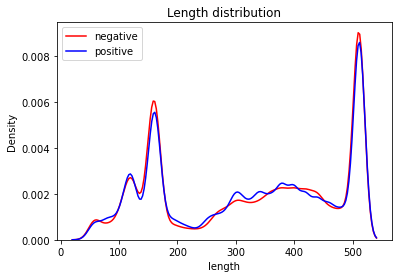

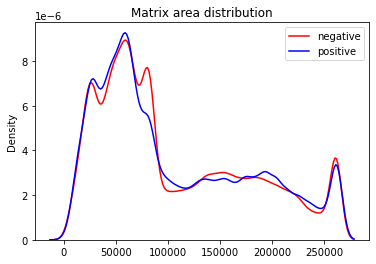

In [196]:
sns.kdeplot(df_len[df_len.label == 'n'].length, color = 'red', label = 'negative')
sns.kdeplot(df_len[df_len.label == 'p'].length, color = 'blue', label = 'positive')
plt.title(f'Length distribution')
plt.legend()
plt.show()
sns.kdeplot(matrix_area_neg, color = 'red', label = 'negative')
sns.kdeplot(matrix_area_pos, color = 'blue', label = 'positive')
plt.title(f'Matrix area distribution')
plt.legend()
plt.show()

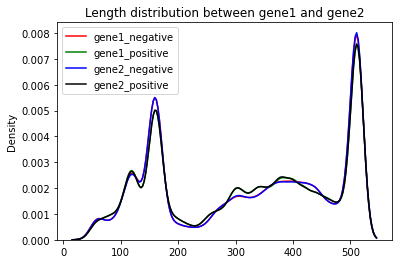

In [197]:
sns.kdeplot(neg_len_1, color = 'red', label = 'gene1_negative')
sns.kdeplot(pos_len_1, color = 'green', label = 'gene1_positive')
sns.kdeplot(neg_len_2, color = 'blue', label = 'gene2_negative')
sns.kdeplot(pos_len_2, color = 'black', label = 'gene2_positive')
plt.title(f'Length distribution between gene1 and gene2')
plt.legend()
plt.show()

In [188]:
small_l = df_len.length.quantile(0.1)
print(df_len[df_len['length'] < small_l].label.value_counts())
print('\n')
big_l = df_len.length.quantile(0.8)
print(df_len[df_len['length'] > big_l].label.value_counts())

p    87818
n    84495
Name: label, dtype: int64


n    182982
p    169017
Name: label, dtype: int64
